# train dataset

In [2]:
import os
import glob
import numbers
import mxnet as mx
import numpy as np
import queue as Queue
import threading
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")
DATA_DIR = "/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/ms1mv2"

rec = os.path.join(DATA_DIR, 'train.rec')
idx = os.path.join(DATA_DIR, 'train.idx')

class MXFaceDataset(Dataset):
    def __init__(self, path_imgrec, path_imgidx, local_rank):
        super(MXFaceDataset, self).__init__()
        self.transform = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
             ])
        self.local_rank = local_rank
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)
        if header.flag > 0:
            self.header0 = (int(header.label[0]), int(header.label[1]))
            self.imgidx = np.array(range(1, int(header.label[0])))
        else:
            self.imgidx = np.array(list(self.imgrec.keys))

    def __getitem__(self, index):
        idx = self.imgidx[index]
        s = self.imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        if not isinstance(label, numbers.Number):
            label = label[0]
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, label

    def __len__(self):
        return len(self.imgidx)

if os.path.exists(rec) and os.path.exists(idx):
    train_set = MXFaceDataset(path_imgrec=rec, path_imgidx=idx, local_rank=0)
else:
    raise Exception(f"dosen exist {rec} file and {idx} file")

In [38]:
total = set({})
total.add(1)
total.add(1)
total.add(2)
total.add(3)
total.add(3)
print(total)
print(len(total))

{1, 2, 3}
3


In [43]:
print(f"{len(train_set):,}")
print(len(train_set[0]))
print(train_set[0][0].shape)
print(train_set[0][1])
print()
total_ids = set({})
for _,id in train_set:
    total_ids.add(id)
print(len(total_ids))

5,822,653
2
torch.Size([3, 112, 112])
tensor(0)



KeyboardInterrupt: 

In [15]:
import random
print(random.randint(0,85000))

70571


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5822653
2


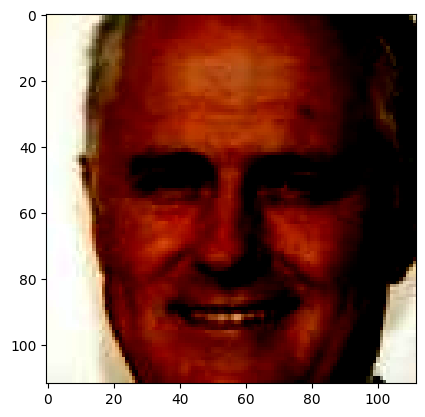

torch.Size([3, 112, 112])
34345


In [22]:
import matplotlib.pyplot as plt

print(len(train_set))
print(len(train_set[0]))

import random
# print(random.randint(0,85000))
ID = random.randint(0,5822653)
plt.imshow(train_set[ID][0].permute(1,2,0))
plt.show()
print(train_set[ID][0].shape)
# print(train_set[0][1].type(torch.IntTensor))
print(int(train_set[ID][1]))

In [18]:
train_loader = DataLoader(dataset=train_set,
                          batch_size=128,
                          shuffle=False,
                          num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 112, 112])
torch.Size([128])


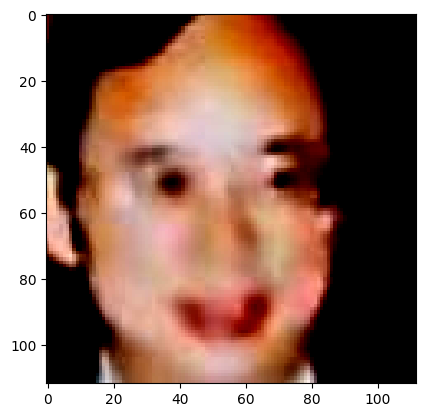

tensor(1)


In [19]:
idx = 127
for inputs, targets in train_loader:
    print(inputs.shape)
    print(targets.shape)
    plt.imshow(inputs[idx].permute(1,2,0))
    plt.show()
    print(targets[idx])
    break

In [3]:
import os
import glob
import numbers
import mxnet as mx
import numpy as np
import queue as Queue
import threading
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class BackgroundGenerator(threading.Thread):
    def __init__(self, generator, local_rank, max_prefetch=6):
        super(BackgroundGenerator, self).__init__()
        self.queue = Queue.Queue(max_prefetch)
        self.generator = generator
        self.local_rank = local_rank
        self.daemon = True
        self.start()

    def run(self):
        torch.cuda.set_device(self.local_rank)
        for item in self.generator:
            self.queue.put(item)
        self.queue.put(None)

    def next(self):
        next_item = self.queue.get()
        if next_item is None:
            raise StopIteration
        return next_item

    def __next__(self):
        return self.next()

    def __iter__(self):
        return self


class NEWDataLoader(DataLoader):

    def __init__(self, local_rank, **kwargs):
        super(NEWDataLoader, self).__init__(**kwargs)
        self.stream = torch.cuda.Stream(local_rank)
        self.local_rank = local_rank

    def __iter__(self):
        self.iter = super(NEWDataLoader, self).__iter__()
        self.iter = BackgroundGenerator(self.iter, self.local_rank)
        self.preload()
        return self

    def preload(self):
        self.batch = next(self.iter, None)
        if self.batch is None:
            return None
        with torch.cuda.stream(self.stream):
            for k in range(len(self.batch)):
                self.batch[k] = self.batch[k].to(device=self.local_rank, non_blocking=True)

    def __next__(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        batch = self.batch
        if batch is None:
            raise StopIteration
        self.preload()
        return batch

train_loader = NEWDataLoader(
    local_rank=0,
    dataset=train_set,
    batch_size=64,
    num_workers=4
)

In [4]:
idx = 127
for inputs, targets in train_loader:
    print(inputs.shape)
    print(targets.shape)
    plt.imshow(inputs[idx].detach().cpu().permute(1,2,0))
    plt.show()
    print(targets[idx])
    break

torch.Size([64, 3, 112, 112])
torch.Size([64])


NameError: name 'plt' is not defined

In [27]:
import os
import glob
import numbers
import mxnet as mx
import numpy as np
import queue as Queue
import threading
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
# import albumentations as A
DATA_DIR = "/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/faces_emore"

def get_train_dataloader(
        root_dir,
        # local_rank,
        # batch_size,
        dali = False,
        seed = 2048,
        num_workers = 2,
    ):
    """
        local_rank: GPU number

    """
    rec = os.path.join(root_dir, 'train.rec')
    idx = os.path.join(root_dir, 'train.idx')
    
    if os.path.exists(rec) and os.path.exists(idx):
        train_set = MXFaceDataset(path_imgrec=rec, path_imgidx=idx, local_rank=0)
    else:
        raise Exception(f"dosen exist {rec} file and {idx} file")

    # train_loader = 
    return train_set


class MXFaceDataset(Dataset):
    def __init__(self, path_imgrec, path_imgidx, local_rank):
        super(MXFaceDataset, self).__init__()
        self.transform = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
             ])
        self.local_rank = local_rank
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)
        if header.flag > 0:
            self.header0 = (int(header.label[0]), int(header.label[1]))
            self.imgidx = np.array(range(1, int(header.label[0])))
        else:
            self.imgidx = np.array(list(self.imgrec.keys))

    def __getitem__(self, index):
        idx = self.imgidx[index]
        s = self.imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        if not isinstance(label, numbers.Number):
            label = label[0]
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, label

    def __len__(self):
        return len(self.imgidx)

class BackgroundGenerator(threading.Thread):
    def __init__(self, generator, local_rank, max_prefetch=6):
        super(BackgroundGenerator, self).__init__()
        self.queue = Queue.Queue(max_prefetch)
        self.generator = generator
        self.local_rank = local_rank
        self.daemon = True
        self.start()

    def run(self):
        torch.cuda.set_device(self.local_rank)
        for item in self.generator:
            self.queue.put(item)
        self.queue.put(None)

    def next(self):
        next_item = self.queue.get()
        if next_item is None:
            raise StopIteration
        return next_item

    def __next__(self):
        return self.next()

    def __iter__(self):
        return self


class DataLoaderX(DataLoader):

    def __init__(self, local_rank, **kwargs):
        super(DataLoaderX, self).__init__(**kwargs)
        self.stream = torch.cuda.Stream(local_rank)
        self.local_rank = local_rank

    def __iter__(self):
        self.iter = super(DataLoaderX, self).__iter__()
        self.iter = BackgroundGenerator(self.iter, self.local_rank)
        self.preload()
        return self

    def preload(self):
        self.batch = next(self.iter, None)
        if self.batch is None:
            return None
        with torch.cuda.stream(self.stream):
            for k in range(len(self.batch)):
                self.batch[k] = self.batch[k].to(device=self.local_rank, non_blocking=True)

    def __next__(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        batch = self.batch
        if batch is None:
            raise StopIteration
        self.preload()
        return batch

In [28]:
train_set = get_train_dataloader(root_dir=DATA_DIR)

/tmp/ipykernel_6046/1615421766.py:49: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5822653
2


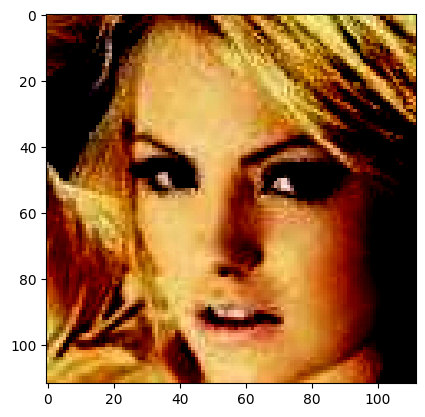

torch.Size([3, 112, 112])
0


In [42]:
import matplotlib.pyplot as plt
print(len(train_set))
print(len(train_set[0]))

plt.imshow(train_set[0][0].permute(1,2,0))
plt.show()
print(train_set[0][0].shape)
# print(train_set[0][1].type(torch.IntTensor))
print(int(train_set[0][1]))

# valid dataset

## 01 - failed

In [22]:
import pickle
from mxnet import ndarray as nd

def load_bin(path, image_size):
    try:
        with open(path, 'rb') as f:
            bins, issame_list = pickle.load(f)  # py2
    except UnicodeDecodeError as e:
        with open(path, 'rb') as f:
            bins, issame_list = pickle.load(f, encoding='bytes')  # py3
    data_list = []
    for flip in [0, 1]:
        data = torch.empty((len(issame_list) * 2, 3, image_size[0], image_size[1]))
        data_list.append(data)
    for idx in range(len(issame_list) * 2):
        _bin = bins[idx]
        img = mx.image.imdecode(_bin)
        if img.shape[1] != image_size[0]:
            img = mx.image.resize_short(img, image_size[0])
        img = nd.transpose(img, axes=(2, 0, 1))
        for flip in [0, 1]:
            if flip == 1:
                img = mx.ndarray.flip(data=img, axis=2)
            data_list[flip][idx][:] = torch.from_numpy(img.asnumpy())
        if idx % 1000 == 0:
            print('loading bin', idx)
    print(data_list[0].shape)
    return data_list, issame_list

val_targets = ["lfw", "cfp_fp", "agedb_30"]
val_datasets = []
for name in val_targets:
    path = os.path.join(DATA_DIR, name+".bin")
    if os.path.exists(path):
        print(path)
        val_datasets.append(load_bin(path, (112,112)))
        

/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/faces_emore/lfw.bin
loading bin 0
loading bin 1000
loading bin 2000
loading bin 3000
loading bin 4000
loading bin 5000
loading bin 6000
loading bin 7000
loading bin 8000
loading bin 9000
loading bin 10000
loading bin 11000
torch.Size([12000, 3, 112, 112])
/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/faces_emore/cfp_fp.bin
loading bin 0
loading bin 1000
loading bin 2000
loading bin 3000
loading bin 4000
loading bin 5000
loading bin 6000
loading bin 7000
loading bin 8000
loading bin 9000
loading bin 10000
loading bin 11000
loading bin 12000
loading bin 13000
torch.Size([14000, 3, 112, 112])
/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/faces_emore/agedb_30.bin
loading bin 0
loading bin 1000
loading bin 2000
loading bin 3000
loading bin 4000
loading bin 5000
loading bin 6000
loading bin 7000
loading bin 8000
loading bin 9000
loading bin 10000
loadi

In [44]:
print(len(val_datasets))        # lfw, cfp, agedb_30
print(len(val_datasets[0]))     # data_list, issame_list
print()

print(type(val_datasets[0][0])) # class list
print(len(val_datasets[0][0]))
print(type(val_datasets[0][1])) # class list
print(len(val_datasets[0][1]))
print()

print(type(val_datasets[0][0][0]))
print(val_datasets[0][0][0].shape)
print(type(val_datasets[0][0][1]))
print(val_datasets[0][0][1].shape)
print()

print(type(val_datasets[0][1][0]))
print(val_datasets[0][1][0])
print(type(val_datasets[0][1][2]))
print(val_datasets[0][1][2])

3
2

<class 'list'>
2
<class 'list'>
6000

<class 'torch.Tensor'>
torch.Size([12000, 3, 112, 112])
<class 'torch.Tensor'>
torch.Size([12000, 3, 112, 112])

<class 'bool'>
True
<class 'bool'>
True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 112, 112])


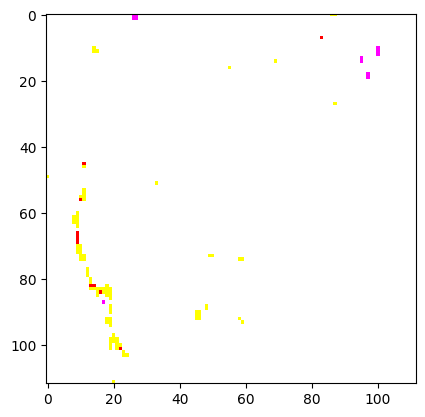

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 112, 112])


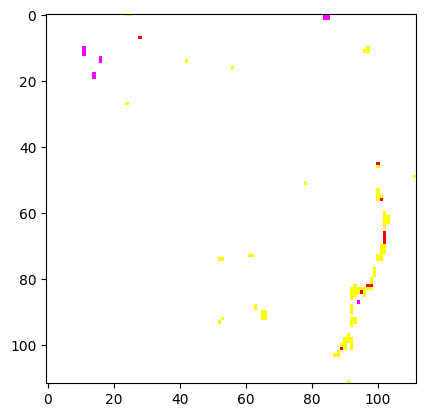

In [49]:
idx = 10
print(val_datasets[0][0][0][0].shape)
plt.imshow(val_datasets[0][0][0][idx].permute(1,2,0))
plt.show()

print(val_datasets[0][0][1][0].shape)
plt.imshow(val_datasets[0][0][1][idx].permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 112, 112])


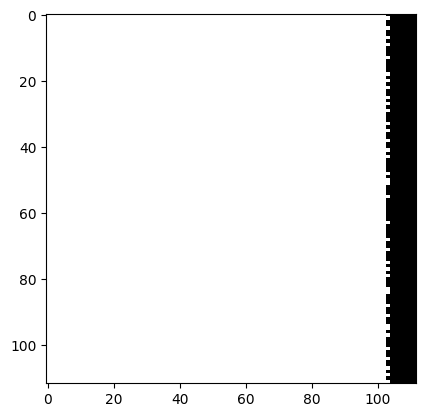

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 112, 112])


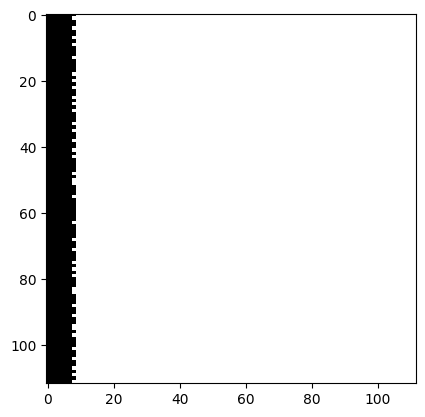

In [51]:
num = 2
idx = 10
print(val_datasets[num][0][0][0].shape)
plt.imshow(val_datasets[num][0][0][idx].permute(1,2,0))
plt.show()

print(val_datasets[num][0][1][0].shape)
plt.imshow(val_datasets[num][0][1][idx].permute(1,2,0))
plt.show()

## 02 - lfw

In [11]:
import glob
import os
DATA_DIR = "/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw"

file_list = glob.glob(os.path.join(DATA_DIR,"*"))
sorted_list = sorted(file_list, key=lambda x: x.split("/")[-1])
print(sorted_list[0:5])
print()
print(file_list[0:5])
print()
print("the total number of IDs: ",len(file_list))

total_img = 0
more_than_two_img = 0
total_more_than_two_img = 0
for file in file_list:
    L = glob.glob(os.path.join(file, "*"))
    if len(L) > 1:
        # print("a")
        total_img += len(L)
        total_more_than_two_img += len(L)
        more_than_two_img += 1
        # print(len(L))
        # print(L)
    else:
        total_img += 1

print("the number of images: ",total_img)
print("-"*50)
print("the number of IDs with more than one image: ",more_than_two_img)
print("the number of imagess with more than one image: ",total_more_than_two_img)

['/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw/AJ_Cook', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw/AJ_Lamas', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw/Aaron_Eckhart', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw/Aaron_Guiel', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw/Aaron_Patterson']

['/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw/Emily_Mortimer', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw/Paul_Wellstone', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw/Tom_Gamboa', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw/Roberto_Tovar', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw/Jan_De_Bont']

the total number of 

In [1]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
DATA_DIR = "/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/lfw"

class Transforms:
    normalize = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
    test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*normalize)
    ])

test_dataset = ImageFolder(DATA_DIR, transform=Transforms.test)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13233
2
torch.Size([3, 250, 250])


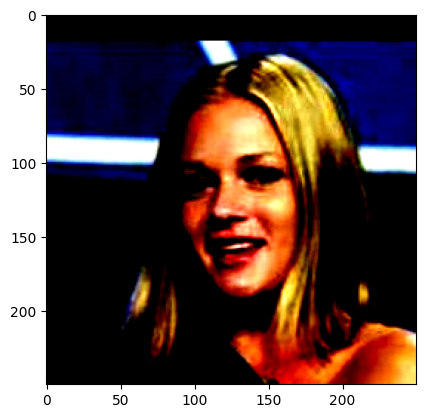

ID:  0


In [2]:
import matplotlib.pyplot as plt
# print(type(test_loader))
print(len(test_dataset))
print(len(test_dataset[0]))
print(test_dataset[0][0].shape)
plt.imshow(test_dataset[0][0].permute(1,2,0))
plt.show()
print("ID: ",test_dataset[0][1])

# test dataset

# test

In [43]:
import torch
x = torch.tensor([1,2,3])
print(x)

x = x.type(torch.DoubleTensor)
print(x)

x = x.type(torch.IntTensor)
print(x)

tensor([1, 2, 3])
tensor([1., 2., 3.], dtype=torch.float64)
tensor([1, 2, 3], dtype=torch.int32)


In [6]:
import torch
s1 = torch.cuda.Stream()
s2 = torch.cuda.Stream()
# Initialise cuda tensors here. E.g.:
A = torch.rand(1000, 1000, device = 'cuda')
print(A.shape)
B = torch.rand(1000, 1000, device = 'cuda')
print(B.shape)
# Wait for the above tensors to initialise.
torch.cuda.synchronize()
with torch.cuda.stream(s1):
    C = torch.mm(A, A)
    print("C shape:",C.shape)
with torch.cuda.stream(s2):
    D = torch.mm(B, B)
    print("D shape:",D.shape)
# Wait for C and D to be computed.
torch.cuda.synchronize()
# Do stuff with C and D.
 

torch.Size([1000, 1000])
torch.Size([1000, 1000])
C shape: torch.Size([1000, 1000])
D shape: torch.Size([1000, 1000])


In [14]:
import torch

# 현재 Setup 되어있는 device 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
print(torch.cuda.get_device_name(device))
print()

print('------------change GPU------------')
# GPU 할당 변경하기
GPU_NUM = 2 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device()) # check
print()

print('------------change GPU------------')
# GPU 할당 변경하기
GPU_NUM = 1 # 원하는 GPU 번호 입력
torch.cuda.set_device(GPU_NUM) # change allocation of current GPU
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device()) # check
print()

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('** Memory Usage **')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Available devices  10
Current cuda device  2
NVIDIA GeForce RTX 3090

------------change GPU------------
Available devices  10
Current cuda device  2

------------change GPU------------
Available devices  10
Current cuda device  1

NVIDIA GeForce RTX 3090
** Memory Usage **
Allocated: 0.0 GB
Cached:    0.0 GB


In [12]:
import torch
import torchvision.models as m
model = m.resnet18()
input = torch.randn((32,3,224,224))
output = model(input)
print(output.shape)

torch.Size([32, 1000])


In [18]:
import torch
output = torch.randn((32,10))
target = torch.randint(low=0, high=10, size=(32,))

In [20]:
total = 0
correct = 0
_, predicted = torch.max(output.data, dim=1)
print(predicted)
print(target)
# total += target.size(0)
# correct += predicted.eq(target.data).cpu().sum()

# print(100*correct/total)

tensor([7, 9, 6, 8, 7, 2, 6, 6, 6, 6, 0, 2, 6, 4, 0, 0, 2, 5, 3, 9, 8, 0, 1, 3,
        9, 0, 3, 0, 9, 1, 3, 3])
tensor([0, 7, 8, 5, 4, 7, 1, 7, 1, 1, 7, 8, 4, 1, 6, 5, 9, 1, 0, 7, 4, 8, 6, 6,
        2, 3, 2, 4, 8, 3, 2, 3])


In [25]:
topk=(1,)
maxk = max(topk)
print(maxk)
print(target.size(0))
print(target.size())

1
32
torch.Size([32])


In [35]:
output = torch.tensor([[1.,5.,3.,6.,2.],[1.,5.,3.,2.,7.],[1.,5.,3.,8.,2.],[1.,9.,3.,1.,2.]])
print(output.shape)
pred = output.topk(maxk, 1, True, True)
print(pred)

torch.Size([4, 5])
torch.return_types.topk(
values=tensor([[6.],
        [7.],
        [8.],
        [9.]]),
indices=tensor([[3],
        [4],
        [3],
        [1]]))


In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True) # pred == the order or argmax
    pred = pred.T
    correct = pred.eq(target.reshape(1, -1).expand_as(pred)) # correct is boolean

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        wrong_k = batch_size - correct_k
        res.append(wrong_k.mul_(100.0 / batch_size))

    return res

In [12]:
import torch.nn as nn
from torchvision import models
model = models.resnet18()
model = nn.DataParallel(model)
if isinstance(model, nn.DataParallel):
    print("true")
else:
    print("false")
# print(model)

true


In [26]:
import os
root_dir="/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/"
print(os.path.join(root_dir, "ms1mv2", "train.rec"))

/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/data/ms1mv2/train.rec


In [1]:
from dataset import get_dataloader

train_loader, x, valid_loader, y = get_dataloader(local_rank=0, batch_size=12)
print(len(train_loader))
print(len(valid_loader))


train dataset length:  5,822,653
valid dataset length:  13,233
485222
1103


In [46]:
import torch
embed_size = 512
num_class = 85742
x = torch.normal(0,0.01,(num_class,embed_size))
print(x.shape)
model = torch.nn.Parameter(x)
print(model.shape)
# print('=> the number of model parameters: {:,}'.format(sum([p.data.nelement() for p in model.parameters()])))

torch.Size([85742, 512])
torch.Size([85742, 512])


In [47]:
x = torch.tensor([1.2,0.5,-1.3])
print(x)
x = x.clamp(-1,1)
print(x)

tensor([ 1.2000,  0.5000, -1.3000])
tensor([ 1.0000,  0.5000, -1.0000])


In [48]:
import torch
import math


class CombinedMarginLoss(torch.nn.Module):
    def __init__(self, 
                 s, 
                 m1,
                 m2,
                 m3,
                 interclass_filtering_threshold=0):
        super().__init__()
        self.s = s
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.interclass_filtering_threshold = interclass_filtering_threshold
        
        # For ArcFace
        self.cos_m = math.cos(self.m2)
        self.sin_m = math.sin(self.m2)
        self.theta = math.cos(math.pi - self.m2)
        self.sinmm = math.sin(math.pi - self.m2) * self.m2
        self.easy_margin = False


    def forward(self, logits, labels):
        index_positive = torch.where(labels != -1)[0]

        if self.interclass_filtering_threshold > 0:
            with torch.no_grad():
                dirty = logits > self.interclass_filtering_threshold
                dirty = dirty.float()
                mask = torch.ones([index_positive.size(0), logits.size(1)], device=logits.device)
                mask.scatter_(1, labels[index_positive], 0)
                dirty[index_positive] *= mask
                tensor_mul = 1 - dirty    
            logits = tensor_mul * logits

        target_logit = logits[index_positive, labels[index_positive].view(-1)]

        if self.m1 == 1.0 and self.m3 == 0.0:
            sin_theta = torch.sqrt(1.0 - torch.pow(target_logit, 2))
            cos_theta_m = target_logit * self.cos_m - sin_theta * self.sin_m  # cos(target+margin)
            if self.easy_margin:
                final_target_logit = torch.where(
                    target_logit > 0, cos_theta_m, target_logit)
            else:
                final_target_logit = torch.where(
                    target_logit > self.theta, cos_theta_m, target_logit - self.sinmm)
            logits[index_positive, labels[index_positive].view(-1)] = final_target_logit
            logits = logits * self.s
        
        elif self.m3 > 0:
            final_target_logit = target_logit - self.m3
            logits[index_positive, labels[index_positive].view(-1)] = final_target_logit
            logits = logits * self.s
        else:
            raise        

        return logits

class ArcFace(torch.nn.Module):
    """ ArcFace (https://arxiv.org/pdf/1801.07698v1.pdf):
    """
    def __init__(self, s=64.0, margin=0.5):
        super(ArcFace, self).__init__()
        self.scale = s
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.theta = math.cos(math.pi - margin)
        self.sinmm = math.sin(math.pi - margin) * margin
        self.easy_margin = False


    def forward(self, logits: torch.Tensor, labels: torch.Tensor):
        index = torch.where(labels != -1)[0]
        target_logit = logits[index, labels[index].view(-1)]

        sin_theta = torch.sqrt(1.0 - torch.pow(target_logit, 2))
        cos_theta_m = target_logit * self.cos_m - sin_theta * self.sin_m  # cos(target+margin)
        if self.easy_margin:
            final_target_logit = torch.where(
                target_logit > 0, cos_theta_m, target_logit)
        else:
            final_target_logit = torch.where(
                target_logit > self.theta, cos_theta_m, target_logit - self.sinmm)

        logits[index, labels[index].view(-1)] = final_target_logit
        logits = logits * self.scale
        return logits


class CosFace(torch.nn.Module):
    def __init__(self, s=64.0, m=0.40):
        super(CosFace, self).__init__()
        self.s = s
        self.m = m

    def forward(self, logits: torch.Tensor, labels: torch.Tensor):
        index = torch.where(labels != -1)[0]
        target_logit = logits[index, labels[index].view(-1)]
        final_target_logit = target_logit - self.m
        logits[index, labels[index].view(-1)] = final_target_logit
        logits = logits * self.s
        return logits

In [50]:
import torch
from typing import Callable
from torch.nn.functional import linear, normalize

class FCSoftmax(nn.Module):
    def __init__(self, margin_softmax: Callable, embed_size: int, num_classes: int):
        super(FCSoftmax, self).__init__()
        self.margin_softmax = margin_softmax
        self.weights = torch.nn.Parameter(torch.FloatTensor(num_classes, embed_size))
        nn.init.xavier_uniform_(self.weights)
    
    def forward(self, embed_vec: torch.Tensor, labels: torch.Tensor):
        logits = linear(normalize(embed_vec), normalize(self.weights)).clamp(-1,1)
        logits = self.margin_softmax(logits, labels)
        return logits



In [54]:
for input, labels in train_loader:
    print(input.shape)
    print(labels.shape)
    break

TypeError: iter() returned non-iterator of type 'CustomDataLoader'

In [52]:
outputs = torch.randn((6,3,112,112))
labels = torch.randint(low=0,high=100,size=(6,))
print(outputs.shape)
print(labels.shape)

# fc_softmax = FCSoftmax()
# margin_loss = CombinedMarginLoss(64, 1.0, 0.5, 0.0)

# model = PartialFC(margin_loss, 512, 93431, 1.0, True)

torch.Size([6, 3, 112, 112])
torch.Size([6])


In [2]:
import torch
checkpoint = torch.load("/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train/weights/rank_0_softmax_weight.pt")
# checkpoint["weights"]

In [3]:
print(type(checkpoint))
print(checkpoint.shape)

<class 'torch.Tensor'>
torch.Size([11398, 512])


In [4]:
from marginloss import CombinedMarginLoss
from fclayer import FCSoftmax

margin_loss = CombinedMarginLoss(64, 1.0, 5.0, 0.0)
fc_softmax = FCSoftmax(margin_loss, 512, 11398)


In [5]:
print(type(fc_softmax.weights))
print(type(fc_softmax.weights.data))
print((fc_softmax.weights.data).shape)
print((fc_softmax.weights.data)[0,0])

<class 'torch.nn.parameter.Parameter'>
<class 'torch.Tensor'>
torch.Size([11398, 512])
tensor(0.0005)


In [8]:
print((fc_softmax.weights.data.device))

cuda:0


In [6]:
fc_softmax.load_state_dict(checkpoint)

In [7]:
print((fc_softmax.weights.data)[0,0])

tensor(-0.0071, device='cuda:0')


In [11]:
i = 32
print(i%100)
i = 1133
print(i%100)

32
33
